In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# The GPU id to use, usually either "0" or "1"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [50]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size = 20
epochs=25
num_worker = 0
lr=0.01
valid_size = 0.2

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

num_train = len(train_data)
indices = np.arange(num_train)
np.random.shuffle(indices)
#Modify a sequence in-place

split = int(valid_size * num_train)

train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_worker,sampler=train_sampler)


valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_worker)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_worker,shuffle=True)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


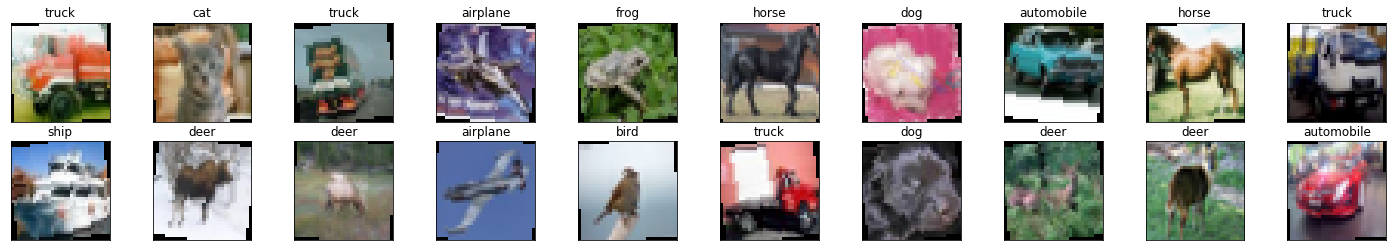

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
    img = img / 2 + 0.5  # unnormalize    
    plt.imshow(np.transpose(img, (1, 2, 0)))  
    
images, labels = next(iter(train_loader))
images = images.numpy() 

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

Here, we look at the normalized red, green, and blue (RGB) color channels as three separate, grayscale intensity images.



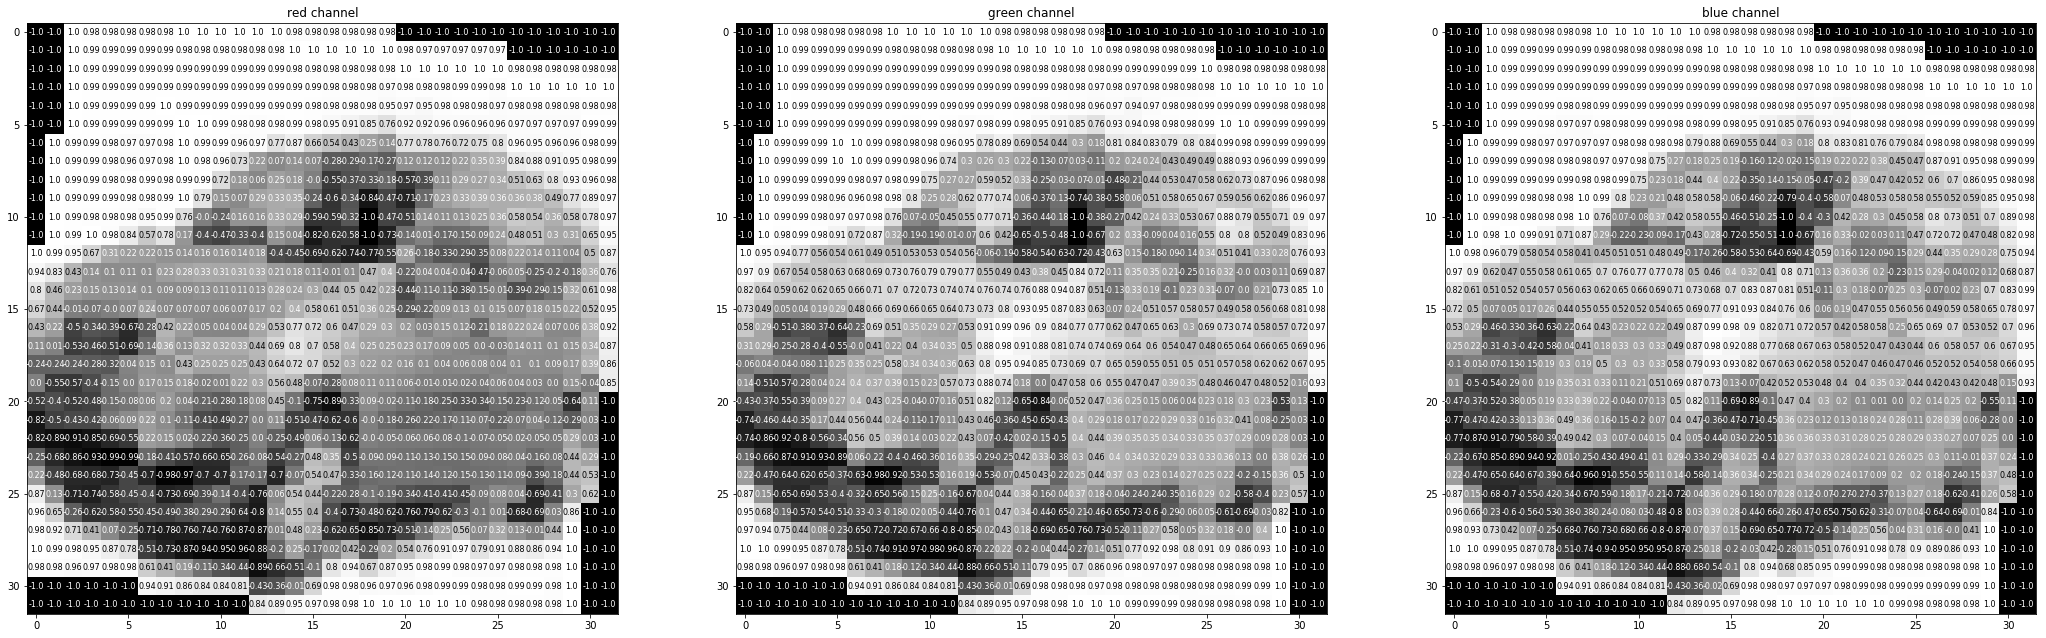

In [4]:
rgb_img = np.squeeze(images[4])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class model(nn.Module):
    def __init__(self):
        super().__init__()        
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        self.fc2 = nn.Linear(500, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) #batch,16,16,16
        
        x = self.pool(F.relu(self.conv2(x)))#batch,32,8,8
        x = self.pool(F.relu(self.conv3(x)))#batch,64,4,4
        x = x.view(-1, 64 * 4 * 4) #batch,64 * 4 * 4
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = model()
model
model.to(device)

model(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25)
)

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

In [8]:
valid_loss_min = np.Inf

for epoch in range(epochs):
    train_loss = 0.0
    valid_loss = 0.0   
    
    model.train()
    for data, target in train_loader:  
        data,target= data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        
        loss = criterion(output, target)        
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.item()*data.size(0)

    model.eval() 
    with torch.no_grad():
        for data, target in valid_loader:
            data,target=data.to(device), target.to(device)
        
            output = model(data)
            loss = criterion(output, target).to(device) 
            valid_loss += loss.item()*data.size(0)
            
        

    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset) 
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,valid_loss
        ))
    
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.714331
Validation loss decreased (inf --> 0.374142).  Saving model ...
Epoch: 2 	Training Loss: 1.383093
Validation loss decreased (0.374142 --> 0.302390).  Saving model ...
Epoch: 3 	Training Loss: 1.217167
Validation loss decreased (0.302390 --> 0.281910).  Saving model ...
Epoch: 4 	Training Loss: 1.141108
Validation loss decreased (0.281910 --> 0.268005).  Saving model ...
Epoch: 5 	Training Loss: 1.077647
Validation loss decreased (0.268005 --> 0.252034).  Saving model ...
Epoch: 6 	Training Loss: 1.019538
Validation loss decreased (0.252034 --> 0.239427).  Saving model ...
Epoch: 7 	Training Loss: 0.971736
Validation loss decreased (0.239427 --> 0.227658).  Saving model ...
Epoch: 8 	Training Loss: 0.925497
Validation loss decreased (0.227658 --> 0.215095).  Saving model ...
Epoch: 9 	Training Loss: 0.886186
Epoch: 10 	Training Loss: 0.851648
Validation loss decreased (0.215095 --> 0.204725).  Saving model ...
Epoch: 11 	Training Loss: 0.821090
Validati

In [9]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() 

for data, target in test_loader:
    data,target= data.to(device), target.to(device)  
    output = model(data)     
    
    loss = criterion(output, target).to(device)  
    test_loss += loss.item()*data.size(0)    
    _, pred = torch.max(output, 1)
    

    correct_tensor = (pred.eq(target.data.view_as(pred)))

    for i in range(batch_size):
        label = target.data[i]

        class_correct[label] += correct_tensor[i].item()

        class_total[label] += 1

test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0: 
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.728529

Test Accuracy of     0: 77% (775/1000)
Test Accuracy of     1: 89% (892/1000)
Test Accuracy of     2: 68% (687/1000)
Test Accuracy of     3: 49% (498/1000)
Test Accuracy of     4: 74% (747/1000)
Test Accuracy of     5: 62% (625/1000)
Test Accuracy of     6: 82% (826/1000)
Test Accuracy of     7: 82% (820/1000)
Test Accuracy of     8: 84% (845/1000)
Test Accuracy of     9: 73% (733/1000)

Test Accuracy (Overall): 74% (7448/10000)


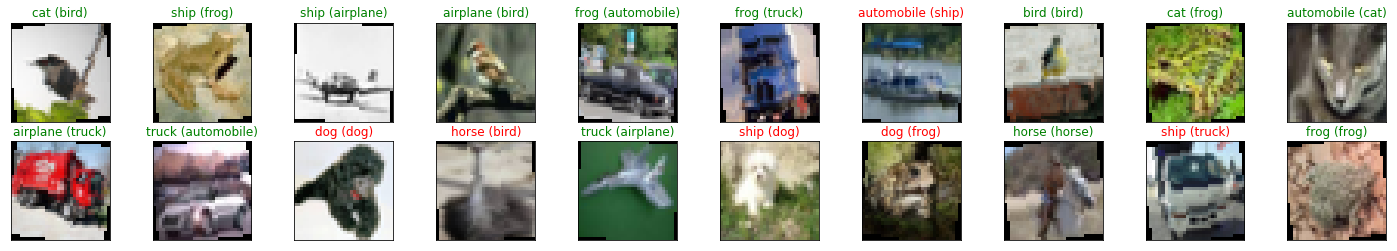

In [58]:
images, labels = next(iter(dataiter))
images, labels  = images.to(device), labels.to(device)

output = model(images)
_, preds_tensor = torch.max(output, 1)
labels= labels.data.view_as(preds_tensor)

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds_tensor[idx]==labels[idx].item() else "red"))

In [33]:
images, labels = next(iter(test_loader))
print(labels)

tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6])
